In [1]:
using LinearAlgebra
using Distributions
using Optim
using Random
using StatsFuns
using JuMP
using MosekTools
using StatsBase
using SparseArrays # 可选，用于处理稀疏性（如果数据量很大）
using FileIO
using JLD2
using Plots
using LaTeXStrings
using DataFrames, Colors
using StatsPlots   # 提供 boxplot，基于 Plots

include("Params_PLD.jl")
include("Data_Generation_PLD.jl")
include("Estimation_PLD.jl")
include("Estimation_PLD_Fast.jl")
include("Models_PLD.jl")
include("Evaluation_PLD.jl")

obtain_profits (generic function with 1 method)

In [2]:
Params = get_default_params_PLD()
N = Params["N"]
N_x = Params["N_x"]
c_l = Params["c_l"]
d_r = Params["d_r"]
rev_gap = Params["rev_gap"]
N_u = Params["N_u"]
S_train = Params["S_train"]
S_test = Params["S_test"]
m = Params["m"]
N_nonzero = Params["N_nonzero"]
Time_Limit = Params["Time_Limit"]
dual_norm = Params["dual_norm"]
gamma_list = Params["gamma_list"]
psi_lb = Params["psi_lb"]
psi_ub = Params["psi_ub"]
phi_lb = Params["phi_lb"]
phi_ub = Params["phi_ub"]
num_c = Params["num_c"]
instances = Params["instances"]
seed = Params["seed"]
coef_this = Params["coef_this"]
coef_Wang_Qi_Shen = Params["coef_Wang_Qi_Shen"]

(alp0_lb = 1.0, alp0_ub = 2.0, alp_lb = -1.0, alp_ub = 1.0, beta_lb = -2.0, beta_ub = 2.0, A_lb = -2.0, A_ub = 2.0, r0_lb = 0.0, r0_ub = 1.0, r_lb = -1.0, r_ub = 1.0)

In [3]:
Random.seed!(seed)
is_Wang_Qi_Shen = true;
if is_Wang_Qi_Shen
    coef_para_Input = coef_Wang_Qi_Shen;
    project_dir = "Wang_Qi_Shen_N=$(N)_N_x=$(N_x)_N_u=$(N_u)_S_train=$(S_train)_N_nonzero=$(N_nonzero)_dr=$(d_r[1])/"
else
    coef_para_Input = coef_this;
    project_dir = "N=$(N)_N_x=$(N_x)_N_u=$(N_u)_S_train=$(S_train)_N_nonzero=$(N_nonzero)_dr=$(d_r[1])/"
end
current_dir = pwd()
parent_dir = dirname(current_dir)
grand_pa_dir = dirname(parent_dir)
data_dir = string(dirname(grand_pa_dir), "/Data/Product_Line_Design/")
data_dir = string(data_dir,project_dir)
if !isdir(data_dir)
    mkpath(data_dir)
end
println("Data directory: ", data_dir)
save(string(data_dir, "Params.jld2"), Params);

Data directory: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/Wang_Qi_Shen_N=1_N_x=10_N_u=1_S_train=50_N_nonzero=5_dr=1.0/


#### Data Generation

In [4]:
function compute_w(params,z_input)
    alpha0 = params.alpha0
    alpha = params.alpha
    beta = params.beta
    A = params.A
    nu0 = alpha0 + beta' * z_input;
    nu = alpha .+ A * z_input;
    return nu0,nu
end

compute_w (generic function with 1 method)

In [5]:
function Generate_Data_this(N_x,N_u,N_nonzero,S_train,S_test,m,coef_Params)
    theta_true, r_params = Generate_Wang_Qi_Max_True_Paras(N_x,N_u,N_nonzero,coef_Params);
    X_train,Y_train,Z_train = Generate_Wang_Qi_Max_True_Data(N_x, N_u, S_train, m,theta_true);
    X_test,Y_test,Z_test = Generate_Wang_Qi_Max_True_Data(N_x, N_u, S_test, m,theta_true);
    Input_Data = Dict()
    Input_Data["theta_true"] = theta_true
    Input_Data["r_params"] = r_params
    Input_Data["X_train"] = X_train
    Input_Data["Y_train"] = Y_train
    Input_Data["Z_train"] = Z_train
    Input_Data["X_test"] = X_test
    Input_Data["Y_test"] = Y_test
    Input_Data["Z_test"] = Z_test
    return Input_Data
end

Generate_Data_this (generic function with 1 method)

In [6]:
function Get_Input_Data(Input_Data)
    theta_true = Input_Data["theta_true"]
    r_params = Input_Data["r_params"]
    X_train = Input_Data["X_train"]
    Y_train = Input_Data["Y_train"]
    Z_train = Input_Data["Z_train"]
    X_test = Input_Data["X_test"]
    Y_test = Input_Data["Y_test"]
    Z_test = Input_Data["Z_test"]

    return theta_true,r_params,X_train,Y_train,Z_train,X_test,Y_test,Z_test
end

Get_Input_Data (generic function with 1 method)

In [7]:
function Estimation_This(lambda,X_train,Y_train,Z_train,N_x,N_u)
    alpha0_hat, alpha_hat, beta_hat, A_hat, opt_result, X_tilde = estimate_parameters_fast(X_train, Y_train, Z_train, lambda, N_x, N_u);
    EST_Para = (alpha0=alpha0_hat, alpha=alpha_hat, beta=beta_hat, A=A_hat)
    return EST_Para
end

Estimation_This (generic function with 1 method)

In [8]:
function solve_ETO_This(S_test,N,N_x,theta_Input,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
    r0 = r_params.r0; r = r_params.r;

    RST_Dict = Dict()
    obj_list = zeros(S_test); x_list = zeros(S_test,N,N_x); time_list = zeros(S_test); profit_list = zeros(S_test); status_list = Vector{String}(undef, S_test)
    status_all = "OPTIMAL"
    for i in 1:S_test
        z_input = Z_test[i,:];
        nu0, nu = compute_w(theta_Input,z_input)
        obj_list[i], x_list[i,:,:], time_list[i],status_list[i] = ETO_PLD(N,N_x,nu0, nu, r0, r,c_l,d_r,rev_gap,num_c,Time_Limit);
        if status_list[i] != "OPTIMAL"
            status_all = status_list[i]
            println("Warning: The optimization for test instance $i did not reach optimality. Status: ", status_list[i])
            break
        end
        profit_list[i] = calculate_profit(theta_true, r0, r, x_list[i,:,:], z_input)                       
    end
    RST_Dict["obj"] = obj_list
    RST_Dict["X"] = x_list
    RST_Dict["time"] = time_list
    RST_Dict["profit"] = profit_list
    RST_Dict["status"] = status_list
    return RST_Dict,status_all
end

solve_ETO_This (generic function with 1 method)

In [9]:
function solve_RO_this(S_test,N,N_x,theta_Input,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
    r0 = r_params.r0; r = r_params.r;
    RST_Dict = Dict();
    
    obj_list = zeros(S_test); x_list = zeros(S_test,N,N_x); time_list = zeros(S_test); profit_list = zeros(S_test); status_list = Vector{String}(undef, S_test)
    status_all = "OPTIMAL"
    for i in 1:S_test
        z_input = Z_test[i,:];                
        nu0, nu = compute_w(theta_Input,z_input)
        obj_list[i], x_list[i,:,:], time_list[i],status_list[i] = RO_PLD(N,N_x,nu0,nu,r0,r,c_l,d_r,rev_gap,psi_lb,psi_ub,phi_lb,phi_ub,gamma,dual_norm,num_c,Time_Limit)
        if status_list[i] != "OPTIMAL"
            status_all = status_list[i]
            println("Warning: The RO optimization for test instance $i did not reach optimality. Status: ", status_list[i])
            break
        end
        profit_list[i] = calculate_profit(theta_true, r0, r, x_list[i,:,:], z_input)
    end
    RST_Dict["obj"] = obj_list
    RST_Dict["X"] = x_list
    RST_Dict["time"] = time_list
    RST_Dict["profit"] = profit_list
    RST_Dict["status"] = status_list
    return RST_Dict,status_all
end

solve_RO_this (generic function with 1 method)

### Lambda = 0.01

In [10]:
lambda = 0.01
Input_Data = Dict()
RST_True_All = Dict()
RST_ETO_All = Dict()
RST_RO_All = Dict()
ins = 1
while ins <= instances
    Input_Data_this = Generate_Data_this(N_x,N_u,N_nonzero,S_train,S_test,m,coef_para_Input)
    theta_true,r_params,X_train,Y_train,Z_train,X_test,Y_test,Z_test = Get_Input_Data(Input_Data_this)
    Input_Data["Input_Data_ins=$(ins)"] = Input_Data_this
    
    theta_Input = theta_true
    RST_True,status_True = solve_ETO_This(S_test,N,N_x,theta_Input,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
    println("Oracle: status = ",status_True,",obj=",RST_True["obj"][1])
    if status_True != "OPTIMAL"
        println("Warning: The true model did not reach optimality")
        continue
    end
    RST_True_All["RST_True_ins=$(ins)"] = RST_True

    theta_hat = Estimation_This(lambda,X_train,Y_train,Z_train,N_x,N_u)
    RST_ETO,status_ETO = solve_ETO_This(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
    println("ETO: status = ",status_ETO,",obj=",RST_ETO["obj"][1])
    if status_ETO != "OPTIMAL"
        println("Warning: The ETO model did not reach optimality")
        continue
    end
    RST_ETO_All["RST_ETO_ins=$(ins)"] = RST_ETO
    
    RST_RO_this = Dict()
    gamma = gamma_list[1]
    RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
    println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
    if status_RO != "OPTIMAL"
        println("Warning: The ETO model did not reach optimality")
        continue
    end
    if abs(RST_RO["profit"][1] - RST_ETO["profit"][1]) > 1e-4
        println("Warning: The RO profit is not equivalent to ETO profit")
        continue
    end
    RST_RO_this[string("gamma=",gamma)] = RST_RO

    for g_index in 2:length(gamma_list)
        gamma = gamma_list[g_index]
        RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
        println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
        RST_RO_this[string("gamma=",gamma)] = RST_RO
    end
    RST_RO_All["RST_RO_ins=$(ins)"] = RST_RO_this
    println("******* ins = ",ins,"*********")
    ins = ins + 1
end
save(string(data_dir, "Input_Data_lambda=$(lambda).jld2"), Input_Data);
save(string(data_dir, "RST_True_lambda=$(lambda).jld2"), RST_True_All);
save(string(data_dir, "RST_ETO_lambda=$(lambda).jld2"), RST_ETO_All);
save(string(data_dir, "RST_RO_lambda=$(lambda).jld2"), RST_RO_All);

Oracle: status = OPTIMAL,obj=1.5848611183983015
  0.000036 seconds (104 allocations: 52.266 KiB)
ETO: status = OPTIMAL,obj=1.7048422067550164
gamma = 0.0, RO: status = OPTIMAL,obj=1.7048421848625288
gamma = 0.025, RO: status = OPTIMAL,obj=1.7006220787383564
gamma = 0.05, RO: status = OPTIMAL,obj=1.696182392893531
gamma = 0.075, RO: status = OPTIMAL,obj=1.6915130301716377
gamma = 0.1, RO: status = OPTIMAL,obj=1.6866024952819347
gamma = 0.2, RO: status = OPTIMAL,obj=1.664334734210762
gamma = 0.4, RO: status = OPTIMAL,obj=1.6047041499516779
gamma = 0.6, RO: status = OPTIMAL,obj=1.5195576878604375
gamma = 0.8, RO: status = OPTIMAL,obj=1.403120816710521
gamma = 1.0, RO: status = OPTIMAL,obj=1.2529676971842716
******* ins = 1*********
Oracle: status = OPTIMAL,obj=2.3331340312269426
  0.000014 seconds (104 allocations: 52.266 KiB)
ETO: status = OPTIMAL,obj=2.1516316196842595
gamma = 0.0, RO: status = OPTIMAL,obj=2.1507201434470775
gamma = 0.025, RO: status = OPTIMAL,obj=2.12986680332437
gamma

In [11]:
profit_True = zeros(instances);
profit_ETO = zeros(instances);
profit_RO = zeros(instances, length(gamma_list));
for ins in 1:instances
    profit_True[ins] = mean(RST_True_All["RST_True_ins=$(ins)"]["profit"])
    profit_ETO[ins] = mean(RST_ETO_All["RST_ETO_ins=$(ins)"]["profit"])
end
println("True profit: mean = ", mean(profit_True), ", std = ", std(profit_True))
println("ETO profit: mean = ", mean(profit_ETO), ", std = ", std(profit_ETO))

True profit: mean = 2.468375613403433, std = 1.0576285107421057
ETO profit: mean = 2.3648824847858543, std = 1.0583664817272873


- Results

In [12]:
Input_Data = load(string(data_dir, "Input_Data_lambda=$(lambda).jld2"));
RST_True_All = load(string(data_dir, "RST_True_lambda=$(lambda).jld2"));
RST_ETO_All = load(string(data_dir, "RST_ETO_lambda=$(lambda).jld2"));
RST_RO_All = load(string(data_dir, "RST_RO_lambda=$(lambda).jld2"));

In [13]:
profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
println("profit True:",round.(mean(profit_True),digits=4))
println("profit ETO:",round.(mean(profit_ETO),digits=4))
println("profit RO:",round.(mean(profit_RO,dims=1),digits=4))

profit True:2.4684
profit ETO:2.3649
profit RO:[2.3649 2.3668 2.3654 2.3639 2.3632 2.3485 2.3092 2.2631 2.2075 2.1411]


- Line plot 

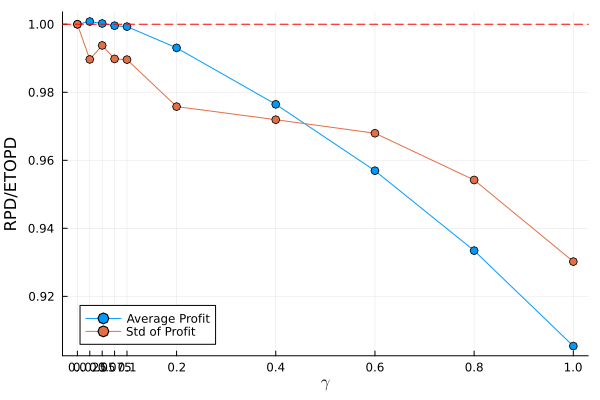

"/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/Wang_Qi_Shen_N=1_N_x=10_N_u=1_S_train=50_N_nonzero=5_dr=1.0/RPLD_vs_ETOPLD_lambda=0.01.pdf"

In [14]:
RO_ETO_Ratio_Mean = (mean(profit_RO,dims=1)/mean(profit_ETO))[1,:];
RO_ETO_Ratio_Std = (std(profit_RO,dims=1)/std(profit_ETO))[1,:];

end_index = length(gamma_list)
plot(gamma_list[1:end_index], RO_ETO_Ratio_Mean[1:end_index], marker=:o, xlabel=L"\gamma", label="Average Profit", xticks=(gamma_list[1:end_index], string.(gamma_list[1:end_index])))
plot!(gamma_list[1:end_index], RO_ETO_Ratio_Std[1:end_index], marker=:o, xlabel=L"\gamma", ylabel="RPD/ETOPD", label="Std of Profit")
hline!([1.0], linestyle=:dash, color=:red, label="")
display(current())
savefig(string(data_dir, "RPLD_vs_ETOPLD_lambda=$lambda.pdf"))

- Boxplot

In [15]:
Profit_ETO_All_Ins = profit_ETO./mean(profit_ETO);
Profit_RO_All_Ins = Dict();
for g_index in 1:length(gamma_list)
    gamma=gamma_list[g_index]
    Profit_RO_All_Ins["gamma=$(gamma)"] = profit_RO[:,g_index]./mean(profit_ETO)
end

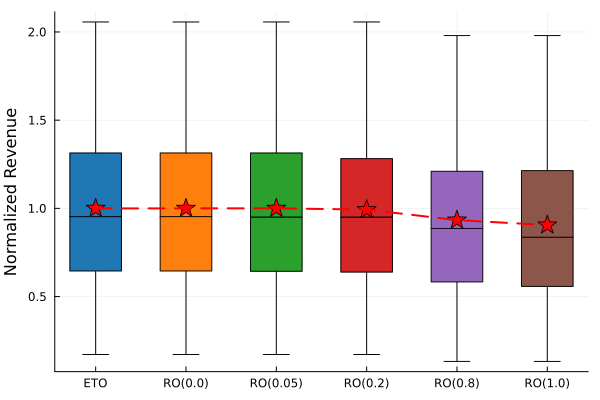

"/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/Wang_Qi_Shen_N=1_N_x=10_N_u=1_S_train=50_N_nonzero=5_dr=1.0/RPLD_vs_ETOPLD_BoxPlot_lambda=0.01.pdf"

In [16]:
chosen_indices = [1,3,6,9,10]
gamma_chosen = gamma_list[chosen_indices]
data = [Profit_ETO_All_Ins, [Profit_RO_All_Ins["gamma=$(gamma)"] for gamma in gamma_chosen]...]
labels = ["ETO"; ["RO($gamma)" for gamma in gamma_chosen]]
# --- 1) 展开成长表 ---
df = DataFrame(
    value = vcat(data...),
    group = repeat(labels, inner = length(data[1]))
)

mycolors = palette(:tab10)[1:length(labels)]   # tab10 最多10个颜色

# --- 3) 绘制箱线图 ---
@df df boxplot(:group, :value;
    group = :group,
    palette = mycolors,
    legend = false,
    ylabel = "Normalized Revenue",
    # title = "Revenue Distribution"
)

# --- 4) 计算均值 ---
means = combine(groupby(df, :group), :value => mean => :mean_val)

for i in 1:length(labels)
    scatter!([labels[i]], [means.mean_val[i]];
        color = :red,
        marker = (:star, 10),
        label = "")
end

# # --- 6) 绘制均值连线（这里必须把类别转为数值 1:N） ---
plot!(labels, means.mean_val;
    seriestype = :line,
    color = :red,
    lw = 2,
    ls = :dash,
    label = "Mean trend"
)
display(current())
savefig(string(data_dir, "RPLD_vs_ETOPLD_BoxPlot_lambda=$lambda.pdf"))

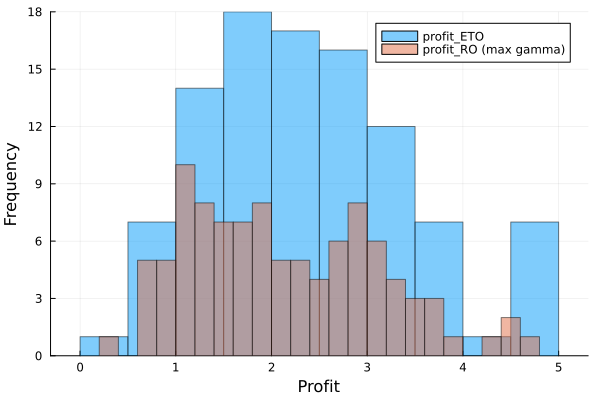

"/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/Wang_Qi_Shen_N=1_N_x=10_N_u=1_S_train=50_N_nonzero=5_dr=1.0/RPLD_vs_ETOPLD_Distribution_lambda=0.01.pdf"

In [17]:
histogram(profit_ETO, alpha=0.5, label="profit_ETO", xlabel="Profit", ylabel="Frequency", legend=:topright, nbins=20)
histogram!(profit_RO[:,length(gamma_list)], alpha=0.5, label="profit_RO (max gamma)", nbins=20)
display(current())
savefig(string(data_dir, "RPLD_vs_ETOPLD_Distribution_lambda=$lambda.pdf"))

# Lambda = 0.0

In [18]:
lambda = 0.0
Input_Data = Dict()
RST_True_All = Dict()
RST_ETO_All = Dict()
RST_RO_All = Dict()
ins = 1
while ins <= instances
    Input_Data_this = Generate_Data_this(N_x,N_u,N_nonzero,S_train,S_test,m,coef_para_Input)
    theta_true,r_params,X_train,Y_train,Z_train,X_test,Y_test,Z_test = Get_Input_Data(Input_Data_this)
    Input_Data["Input_Data_ins=$(ins)"] = Input_Data_this
    
    theta_Input = theta_true
    RST_True,status_True = solve_ETO_This(S_test,N,N_x,theta_Input,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
    println("Oracle: status = ",status_True,",obj=",RST_True["obj"][1])
    if status_True != "OPTIMAL"
        println("Warning: The true model did not reach optimality")
        continue
    end
    RST_True_All["RST_True_ins=$(ins)"] = RST_True

    theta_hat = Estimation_This(lambda,X_train,Y_train,Z_train,N_x,N_u)
    RST_ETO,status_ETO = solve_ETO_This(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
    println("ETO: status = ",status_ETO,",obj=",RST_ETO["obj"][1])
    if status_ETO != "OPTIMAL"
        println("Warning: The ETO model did not reach optimality")
        continue
    end
    RST_ETO_All["RST_ETO_ins=$(ins)"] = RST_ETO
    
    RST_RO_this = Dict()
    gamma = gamma_list[1]
    RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
    println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
    if status_RO != "OPTIMAL"
        println("Warning: The ETO model did not reach optimality")
        continue
    end
    if abs(RST_RO["profit"][1] - RST_ETO["profit"][1]) > 1e-4
        println("Warning: The RO profit is not equivalent to ETO profit")
        continue
    end
    RST_RO_this[string("gamma=",gamma)] = RST_RO

    for g_index in 2:length(gamma_list)
        gamma = gamma_list[g_index]
        RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
        println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
        RST_RO_this[string("gamma=",gamma)] = RST_RO
    end
    RST_RO_All["RST_RO_ins=$(ins)"] = RST_RO_this
    println("******* ins = ",ins,"*********")
    ins = ins + 1
end
save(string(data_dir, "Input_Data_lambda=$(lambda).jld2"), Input_Data);
save(string(data_dir, "RST_True_lambda=$(lambda).jld2"), RST_True_All);
save(string(data_dir, "RST_ETO_lambda=$(lambda).jld2"), RST_ETO_All);
save(string(data_dir, "RST_RO_lambda=$(lambda).jld2"), RST_RO_All);

Oracle: status = OPTIMAL,obj=2.4960662753683107
  0.000017 seconds (104 allocations: 52.266 KiB)
ETO: status = OPTIMAL,obj=2.5381373001743874
gamma = 0.0, RO: status = OPTIMAL,obj=2.5381368699255287
gamma = 0.025, RO: status = OPTIMAL,obj=2.5381370053323526
gamma = 0.05, RO: status = OPTIMAL,obj=2.538136912182572
gamma = 0.075, RO: status = OPTIMAL,obj=2.538137044501082
gamma = 0.1, RO: status = OPTIMAL,obj=2.53813710462245
gamma = 0.2, RO: status = OPTIMAL,obj=2.538137155910026
gamma = 0.4, RO: status = OPTIMAL,obj=2.538136831918767
gamma = 0.6, RO: status = OPTIMAL,obj=2.5381367703089897
gamma = 0.8, RO: status = OPTIMAL,obj=2.5381364376215423
gamma = 1.0, RO: status = OPTIMAL,obj=2.538136949313925
******* ins = 1*********
Oracle: status = OPTIMAL,obj=1.5635229879247536
  0.000016 seconds (104 allocations: 52.266 KiB)
ETO: status = OPTIMAL,obj=1.5777316931737355
gamma = 0.0, RO: status = OPTIMAL,obj=1.577731671828327
gamma = 0.025, RO: status = OPTIMAL,obj=1.5532201899571285
gamma = 

In [19]:
lambda = 0.0
Input_Data = load(string(data_dir, "Input_Data_lambda=$(lambda).jld2"));
RST_True_All = load(string(data_dir, "RST_True_lambda=$(lambda).jld2"));
RST_ETO_All = load(string(data_dir, "RST_ETO_lambda=$(lambda).jld2"));
RST_RO_All = load(string(data_dir, "RST_RO_lambda=$(lambda).jld2"));

In [20]:
profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
println("profit True:",round.(mean(profit_True),digits=4))
println("profit ETO:",round.(mean(profit_ETO),digits=4))
println("profit RO:",round.(mean(profit_RO,dims=1),digits=4))

profit True:2.5946
profit ETO:2.4882
profit RO:[2.4882 2.4888 2.4888 2.4863 2.4874 2.4755 2.4354 2.3848 2.3732 2.3085]


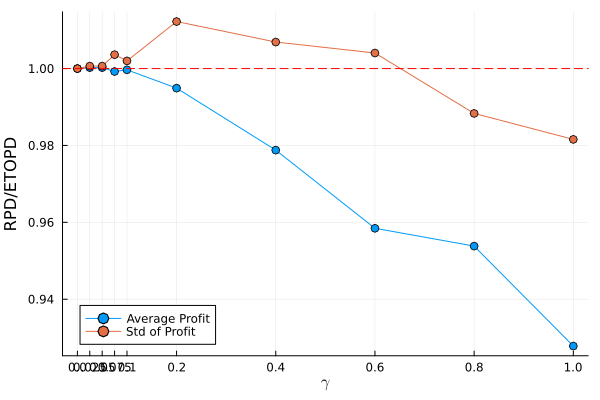

"/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/Wang_Qi_Shen_N=1_N_x=10_N_u=1_S_train=50_N_nonzero=5_dr=1.0/RPLD_vs_ETOPLD_lambda=0.0.pdf"

In [21]:
RO_ETO_Ratio_Mean = (mean(profit_RO,dims=1)/mean(profit_ETO))[1,:];
RO_ETO_Ratio_Std = (std(profit_RO,dims=1)/std(profit_ETO))[1,:];

end_index = length(gamma_list)
plot(gamma_list[1:end_index], RO_ETO_Ratio_Mean[1:end_index], marker=:o, xlabel=L"\gamma", label="Average Profit", xticks=(gamma_list[1:end_index], string.(gamma_list[1:end_index])))
plot!(gamma_list[1:end_index], RO_ETO_Ratio_Std[1:end_index], marker=:o, xlabel=L"\gamma", ylabel="RPD/ETOPD", label="Std of Profit")
hline!([1.0], linestyle=:dash, color=:red, label="")
display(current())
savefig(string(data_dir, "RPLD_vs_ETOPLD_lambda=$lambda.pdf"))

In [22]:
Profit_ETO_All_Ins = profit_ETO./mean(profit_ETO);
Profit_RO_All_Ins = Dict();
for g_index in 1:length(gamma_list)
    gamma=gamma_list[g_index]
    Profit_RO_All_Ins["gamma=$(gamma)"] = profit_RO[:,g_index]./mean(profit_ETO)
end

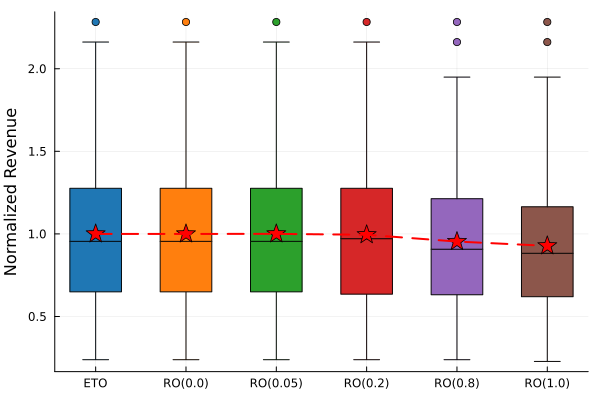

"/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/Wang_Qi_Shen_N=1_N_x=10_N_u=1_S_train=50_N_nonzero=5_dr=1.0/RPLD_vs_ETOPLD_BoxPlot_lambda=0.0.pdf"

In [23]:
chosen_indices = [1,3,6,9,10]
gamma_chosen = gamma_list[chosen_indices]
data = [Profit_ETO_All_Ins, [Profit_RO_All_Ins["gamma=$(gamma)"] for gamma in gamma_chosen]...]
labels = ["ETO"; ["RO($gamma)" for gamma in gamma_chosen]]
# --- 1) 展开成长表 ---
df = DataFrame(
    value = vcat(data...),
    group = repeat(labels, inner = length(data[1]))
)

mycolors = palette(:tab10)[1:length(labels)]   # tab10 最多10个颜色

# --- 3) 绘制箱线图 ---
@df df boxplot(:group, :value;
    group = :group,
    palette = mycolors,
    legend = false,
    ylabel = "Normalized Revenue",
    # title = "Revenue Distribution"
)

# --- 4) 计算均值 ---
means = combine(groupby(df, :group), :value => mean => :mean_val)

for i in 1:length(labels)
    scatter!([labels[i]], [means.mean_val[i]];
        color = :red,
        marker = (:star, 10),
        label = "")
end

# # --- 6) 绘制均值连线（这里必须把类别转为数值 1:N） ---
plot!(labels, means.mean_val;
    seriestype = :line,
    color = :red,
    lw = 2,
    ls = :dash,
    label = "Mean trend"
)
display(current())
savefig(string(data_dir, "RPLD_vs_ETOPLD_BoxPlot_lambda=$lambda.pdf"))

#### Wang_Qi_Max

In [24]:
# lambda = 0.01

# Input_Data_this = Generate_Data_this(N_x,N_u,N_nonzero,S_train,S_test,m,coef_Wang_Qi_Shen)
# theta_true,r_params,X_train,Y_train,Z_train,X_test,Y_test,Z_test = Get_Input_Data(Input_Data_this)

# theta_Input = theta_true
# RST_True,status_True = solve_ETO_This(S_test,N,N_x,theta_Input,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)

# theta_hat = Estimation_This(lambda,X_train,Y_train,Z_train,N_x,N_u)
# RST_ETO,status_ETO = solve_ETO_This(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)

In [25]:
# nu0_true, nu_true = compute_w(theta_true,Z_test[1,:])
# nu0_hat, nu_hat = compute_w(theta_hat,Z_test[1,:])
# println("W true = ", round.([nu0_true; nu_true],digits=4))
# println("W hat  = ", round.([nu0_hat; nu_hat],digits=4))

In [26]:
# println("Price coef = ",round.(r_params.r,digits=4))

In [27]:
# RST_True["X"][1,:,:]

In [28]:
# RST_ETO["X"][1,:,:]

In [29]:
# price_true = RST_True["X"][1,:,:] * r_params.r
# price_eto = RST_ETO["X"][1,:,:] * r_params.r
# println("True Price = ", round.(price_true,digits=4))
# println("ETO  Price = ", round.(price_eto,digits=4))

In [30]:
# util_true = nu0_true .+ RST_True["X"][1,:,:] * nu_true;
# exp_util_true = exp.(util_true);
# prob_util_true = exp_util_true ./ (1+sum(exp_util_true))

In [31]:
# util_hat = nu0_hat .+ RST_ETO["X"][1,:,:] * nu_hat;
# exp_util_hat = exp.(util_hat);
# prob_util_hat = exp_util_hat ./ (1+sum(exp_util_hat))

In [32]:
# println("True rev = ",prob_util_true' * price_true)
# println("True rev = ",prob_util_hat' * price_eto)